In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.preprocessing import sequence

from TransformerComplet import *

from tensorflow.keras.layers import Dense, Dropout, Embedding, Input, Concatenate, MultiHeadAttention


In [4]:

# 1. Prétraitement des Données
benign_stateful_1 = pd.read_csv('../../data/Attack_Benin_1/Benign/Benign/stateful_features-_light_benign.pcap.csv')
benign_stateless_2 = pd.read_csv('../../data/Attack_Benin_1/Benign/Benign/stateless_features-light_benign.pcap.csv')

attack_stateful_1 = pd.read_csv('../../data/Attack_Benin_1/Attacks/Attacks/stateful_features-light_audio.pcap.csv')
attack_stateful_2 = pd.read_csv('../../data/Attack_Benin_1/Attacks/Attacks/stateful_features-light_compressed.pcap.csv')
attack_stateful_3 = pd.read_csv('../../data/Attack_Benin_1/Attacks/Attacks/stateful_features-light_exe.pcap.csv')
attack_stateful_4 = pd.read_csv('../../data/Attack_Benin_1/Attacks/Attacks/stateful_features-light_image.pcap.csv')
attack_stateful_5 = pd.read_csv('../../data/Attack_Benin_1/Attacks/Attacks/stateful_features-light_text.pcap.csv')
attack_stateful_6 = pd.read_csv('../../data/Attack_Benin_1/Attacks/Attacks/stateful_features-light_video.pcap.csv')

attack_stateless_1 = pd.read_csv('../../data/Attack_Benin_1/Attacks/Attacks/stateless_features-light_audio.pcap.csv')
attack_stateless_2 = pd.read_csv('../../data/Attack_Benin_1/Attacks/Attacks/stateless_features-light_compressed.pcap.csv')
attack_stateless_3 = pd.read_csv('../../data/Attack_Benin_1/Attacks/Attacks/stateless_features-light_exe.pcap.csv')
attack_stateless_4 = pd.read_csv('../../data/Attack_Benin_1/Attacks/Attacks/stateless_features-light_image.pcap.csv')
attack_stateless_5 = pd.read_csv('../../data/Attack_Benin_1/Attacks/Attacks/stateless_features-light_text.pcap.csv')
attack_stateless_6 = pd.read_csv('../../data/Attack_Benin_1/Attacks/Attacks/stateless_features-light_video.pcap.csv')



# Exemple pour les données Light Attack
merged_statful_light_attack = pd.concat([attack_stateful_1, attack_stateful_2, attack_stateful_3,attack_stateful_4,attack_stateful_5,attack_stateful_6], axis=0, ignore_index=True)
merged_stateless_light_attack = pd.concat([attack_stateless_1, attack_stateless_2, attack_stateless_3,attack_stateless_4,attack_stateless_5,attack_stateless_6], axis=0, ignore_index=True)



# Exemple intuitif pour les colonnes stateless

### (axis=0) car ils ont les memes colonnes donc ont empile ; (axis=1) colonne different on juxtapose

# Concaténation des données sans redondance
final_benign_data = pd.concat([benign_stateful_1, benign_stateless_2], axis=1).loc[:, ~pd.concat([benign_stateful_1, benign_stateless_2], axis=1).columns.duplicated()]
final_attack_data = pd.concat([merged_stateless_light_attack, merged_statful_light_attack], axis=1).loc[:, ~pd.concat([merged_stateless_light_attack, merged_statful_light_attack], axis=1).columns.duplicated()]

# Ajout des étiquettes après la concaténation


final_benign_data['label'] = 'benign'
final_attack_data['label'] = 'attack'




# Faites de même pour les autres fichiers CSV

In [5]:
print(final_benign_data.dtypes)
print(final_attack_data.dtypes)

print(final_attack_data.shape)
print(final_benign_data.shape)

final_attack_data.isnull().sum().sort_values(ascending=False)
final_benign_data.isnull().sum().sort_values(ascending=False)

# Afficher les noms des colonnes
# print("Colonnes de final_benign_data:", final_benign_data.columns)



rr                  float64
A_frequency         float64
NS_frequency        float64
CNAME_frequency     float64
SOA_frequency       float64
NULL_frequency      float64
PTR_frequency       float64
HINFO_frequency     float64
MX_frequency        float64
TXT_frequency       float64
AAAA_frequency      float64
SRV_frequency       float64
OPT_frequency       float64
rr_type              object
rr_count            float64
rr_name_entropy     float64
rr_name_length      float64
distinct_ns         float64
distinct_ip          object
unique_country       object
unique_asn           object
distinct_domains     object
reverse_dns          object
a_records           float64
unique_ttl           object
ttl_mean            float64
ttl_variance        float64
timestamp            object
FQDN_count            int64
subdomain_length      int64
upper                 int64
lower                 int64
numeric               int64
entropy             float64
special               int64
labels              

rr                  37323
rr_count            37323
ttl_variance        37323
ttl_mean            37323
unique_ttl          37323
a_records           37323
reverse_dns         37323
A_frequency         37323
unique_asn          37323
unique_country      37323
distinct_ip         37323
distinct_ns         37323
rr_name_length      37323
rr_name_entropy     37323
distinct_domains    37323
rr_type             37323
PTR_frequency       37323
OPT_frequency       37323
NS_frequency        37323
CNAME_frequency     37323
NULL_frequency      37323
SOA_frequency       37323
HINFO_frequency     37323
MX_frequency        37323
TXT_frequency       37323
AAAA_frequency      37323
SRV_frequency       37323
longest_word            4
labels                  0
subdomain               0
len                     0
sld                     0
labels_average          0
labels_max              0
subdomain_length        0
special                 0
entropy                 0
numeric                 0
lower       

In [6]:
# 2. Concaténer les données

final_data = pd.concat([final_benign_data, final_attack_data], axis=0, ignore_index=True)

# 3. Supprimer les colonnes redondantes dans les données catégorielles
final_data = final_data.loc[:, ~final_data.columns.duplicated()]

X_numerical = final_data.select_dtypes(include=['int64', 'float64'])

X_categorical = final_data.select_dtypes(exclude='number').drop('label', axis=1)
y = final_data['label']


In [7]:
print(X_numerical.shape)
print(X_categorical.shape)

print(y.shape)

(102774, 32)
(102774, 10)
(102774,)


In [8]:
print(X_numerical.columns)
print(X_categorical.columns)

Index(['rr', 'A_frequency', 'NS_frequency', 'CNAME_frequency', 'SOA_frequency',
       'NULL_frequency', 'PTR_frequency', 'HINFO_frequency', 'MX_frequency',
       'TXT_frequency', 'AAAA_frequency', 'SRV_frequency', 'OPT_frequency',
       'rr_count', 'rr_name_entropy', 'rr_name_length', 'distinct_ns',
       'a_records', 'ttl_mean', 'ttl_variance', 'FQDN_count',
       'subdomain_length', 'upper', 'lower', 'numeric', 'entropy', 'special',
       'labels', 'labels_max', 'labels_average', 'len', 'subdomain'],
      dtype='object')
Index(['rr_type', 'distinct_ip', 'unique_country', 'unique_asn',
       'distinct_domains', 'reverse_dns', 'unique_ttl', 'timestamp',
       'longest_word', 'sld'],
      dtype='object')


In [9]:
print(X_categorical['unique_ttl'])

0                                    [1]
1                     [1, 1, 1, 1, 1, 1]
2                     [1, 1, 1, 1, 1, 1]
3                     [1, 1, 1, 1, 1, 1]
4         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
                       ...              
102769                               NaN
102770                               NaN
102771                               NaN
102772                               NaN
102773                               NaN
Name: unique_ttl, Length: 102774, dtype: object


In [11]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.impute import SimpleImputer


#prepocessing des features numeriques soit  avec le  LabelEncoder soit le MinMaxScaler()

# 2. Vérification des colonnes vides
if X_numerical.isnull().any().any():
    # Imputer les valeurs manquantes pour les caractéristiques numériques
    numerical_imputer = SimpleImputer(strategy='mean')
    X_numerical_imputed = pd.DataFrame(numerical_imputer.fit_transform(X_numerical), columns=X_numerical.columns)

    #prepocessing des features numeriques soit  avec le  LabelEncoder soit le MinMaxScaler()

    # Création d'un scaler
    scaler = MinMaxScaler()

    # Ajustement du scaler aux données
    scaler.fit(X_numerical_imputed)

    # Transformation des fonctionnalités numériques
    # scaled_numeric_features = scaler.transform(X_numerical_combined)

    scaled_numeric_features = scaler.transform(X_numerical_imputed)

    # Apres transformation Création d' un DataFrame à partir des valeurs transformées

    # scaled_df = pd.DataFrame(scaled_numeric_features, columns=X_numerical_combined.columns)
    scaled_df = pd.DataFrame(scaled_numeric_features, columns=X_numerical.columns)


    # Afficher le DataFrame avec les valeurs transformées
    print("Après transformation")
    print(scaled_df)

    total_size = scaled_df.shape

    print("Taille totale des caracteristiques numeriques apres concatenations :", total_size)

else:
    print("Pas de valeurs manquantes dans les caractéristiques numériques. Aucune imputation nécessaire.")

Après transformation
              rr  A_frequency  NS_frequency  CNAME_frequency  SOA_frequency   
0       0.000000     0.000000           0.0              0.0            0.0  \
1       0.000000     0.000000           0.0              0.0            0.0   
2       0.000000     0.000000           0.0              0.0            0.0   
3       0.000000     0.000000           0.0              0.0            0.0   
4       0.000000     0.000000           0.0              0.0            0.0   
...          ...          ...           ...              ...            ...   
102769  0.134923     0.134923           0.0              0.0            0.0   
102770  0.134923     0.134923           0.0              0.0            0.0   
102771  0.134923     0.134923           0.0              0.0            0.0   
102772  0.134923     0.134923           0.0              0.0            0.0   
102773  0.134923     0.134923           0.0              0.0            0.0   

        NULL_frequency  PTR_fr

In [190]:
############# Il y'a un soucis il ne faut pas utiliser le (X_numerical_imputed) ### mais le (scaled_df) qui contient les donnees normalisee ie entre [0 - 1]
############################################################################################################################################################
###############################data_num_rfecv = X_numerical_imputed[['FQDN_count','A_frequency','labels','subdomain_length','lower','TXT_frequency','rr_name_entropy','labels_max','ttl_mean','entropy']]
######################## ne pas executer ceci ########################################################################
data_num_rfecv = scaled_df[['FQDN_count','labels','lower','ttl_mean','rr']]


print(data_num_rfecv)
print(data_num_rfecv.shape)

        FQDN_count  labels     lower  ttl_mean        rr
0         0.735294     1.0  0.294118  0.000000  0.000000
1         0.676471     1.0  0.294118  0.000000  0.000000
2         0.676471     1.0  0.294118  0.000000  0.000000
3         0.735294     1.0  0.294118  0.000000  0.000000
4         0.735294     1.0  0.294118  0.000000  0.000000
...            ...     ...       ...       ...       ...
102769    0.647059     1.0  0.294118  0.257283  0.134923
102770    0.676471     1.0  0.294118  0.257283  0.134923
102771    0.676471     1.0  0.294118  0.257283  0.134923
102772    0.647059     1.0  0.294118  0.257283  0.134923
102773    0.647059     1.0  0.294118  0.257283  0.134923

[102774 rows x 5 columns]
(102774, 5)


In [14]:
from sklearn.impute import SimpleImputer

# Vérification des colonnes vides
if X_categorical.isnull().any().any():
    # Imputer les valeurs manquantes pour les caractéristiques catégorielles
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    X_categorical_imputed = pd.DataFrame(categorical_imputer.fit_transform(X_categorical), columns=X_categorical.columns)

    # Afficher le DataFrame avec les valeurs imputées
    print("Après imputation")
    print(X_categorical_imputed)

    total_size_categorical = X_categorical_imputed.shape

    print("Taille totale des caractéristiques catégorielles après imputation :", total_size_categorical)

else:
    print("Pas de valeurs manquantes dans les caractéristiques catégorielles. Aucune imputation nécessaire.")


Après imputation
        rr_type distinct_ip unique_country unique_asn distinct_domains   
0       {'PTR'}       set()          set()      set()               {}  \
1       {'PTR'}       set()          set()      set()               {}   
2       {'PTR'}       set()          set()      set()               {}   
3       {'PTR'}       set()          set()      set()               {}   
4       {'PTR'}       set()          set()      set()               {}   
...         ...         ...            ...        ...              ...   
102769  {'PTR'}       set()          set()      set()               {}   
102770  {'PTR'}       set()          set()      set()               {}   
102771  {'PTR'}       set()          set()      set()               {}   
102772  {'PTR'}       set()          set()      set()               {}   
102773  {'PTR'}       set()          set()      set()               {}   

       reverse_dns                      unique_ttl   
0          unknown                      

In [15]:
def caluler_moyenne_unique_tls(liste):
    liste_entier = [int(element) for element in liste if element.isdigit()] #convertir les element en entier 
    return sum(liste_entier) / len(liste_entier)

In [17]:

X_categorical_imputed['unique_ttl'] = X_categorical_imputed['unique_ttl'].apply(caluler_moyenne_unique_tls)


In [18]:
print(X_categorical_imputed['unique_ttl'])


0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
102769    1.0
102770    1.0
102771    1.0
102772    1.0
102773    1.0
Name: unique_ttl, Length: 102774, dtype: float64


In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd

X_copy = X_categorical_imputed.copy()

# Appliquer une tokenisation à chaque colonne catégorielle
for feature in X_categorical_imputed.columns.tolist():
    X_copy[feature] = X_copy[feature].astype(str)


# Combinez les colonnes catégorielles dans une colonne 'combined_text'
    
X_copy['combined_text'] = X_copy[X_categorical_imputed.columns.tolist()].apply(lambda row: ' '.join(row), axis=1)
 
# Tokenisation
tokenizer = Tokenizer(num_words=10, filters=' ', split=' ')
tokenizer.fit_on_texts(X_copy['combined_text'])
tokens = tokenizer.texts_to_sequences(X_copy['combined_text'])

# Calcul de la longueur maximale du vecteur
max_sequence_length = max(len(seq) for seq in tokens)

# Ajout des colonnes tokenisées au DataFrame
for i in range(1, max_sequence_length + 1):
    X_copy[f'token_{i}'] = [seq[i - 1] if len(seq) >= i else 0 for seq in tokens]

# Suppression des colonnes originales et la colonne temporaire 'combined_text'
X_copy.drop(columns=X_categorical_imputed.columns.tolist() + ['combined_text'], inplace=True)

# Afficher les tokens et les longueurs de séquence
print("Tokens:")
print(tokens)

print("\nLongueurs de séquence:")
print([len(seq) for seq in tokens])

# Gardez les longueurs des séquences
seq_lengths = [len(seq) for seq in tokens]

# Calcul de la longueur maximale du vecteur
max_sequence_length = max(len(seq) for seq in tokens)

# Affichage de la longueur maximale
print(f"Longueur maximale du vecteur : {max_sequence_length}")


Tokens:
[[6, 1, 1, 1, 3, 2, 5, 4, 7, 8], [6, 1, 1, 1, 3, 2, 5, 4, 7, 8], [6, 1, 1, 1, 3, 2, 5, 4, 7, 8], [6, 1, 1, 1, 3, 2, 5, 4, 7, 8], [6, 1, 1, 1, 3, 2, 5, 4, 7, 8], [6, 1, 1, 1, 3, 2, 5, 4, 7, 8], [6, 1, 1, 1, 3, 2, 5, 4, 7, 8], [6, 1, 1, 1, 3, 2, 5, 4, 9], [6, 1, 1, 1, 3, 2, 5, 4, 9], [6, 1, 1, 1, 3, 2, 5, 4, 7, 8], [6, 1, 1, 1, 3, 2, 5, 4, 7, 8], [6, 1, 1, 1, 3, 2, 5, 4, 7, 8], [6, 1, 1, 1, 3, 2, 5, 4, 7, 8], [1, 4, 9], [1, 4, 9], [1, 4, 7, 8], [1, 4, 7, 8], [1, 1, 1, 3, 2, 4, 7, 8], [1, 1, 1, 3, 2, 4, 7, 8], [6, 1, 1, 1, 3, 2, 5, 4, 9], [1, 2, 4, 9], [1, 1, 1, 3, 2, 4, 7, 8], [6, 1, 1, 1, 3, 2, 4, 7, 8], [6, 1, 1, 1, 3, 2, 4], [1, 4], [6, 1, 1, 1, 3, 2, 5, 4, 9], [1, 1, 1, 3, 2, 4, 9], [1, 1, 1, 3, 2, 4, 7, 8], [1, 2, 4, 7, 8], [6, 1, 1, 1, 3, 2, 5, 4, 7, 8], [1, 4, 7, 8], [1, 4, 7, 8], [6, 1, 1, 1, 3, 2, 5, 4, 7, 8], [1, 4, 9], [1, 1, 1, 3, 2, 4, 9], [1, 1, 1, 3, 2, 4, 7, 8], [1, 4, 7, 8], [1, 4, 7, 8], [1, 4, 7, 8], [1, 4, 9], [6, 1, 1, 1, 3, 2, 5, 4, 9], [1, 1, 1, 3, 2, 4, 7,

In [20]:
#Calcule des statistique descriptive sur les longueur des sequences

mean_length = np.mean(max_sequence_length)
max_length = np.max(max_sequence_length)
min_length = np.min(max_sequence_length)
std_dev = np.std(max_sequence_length)


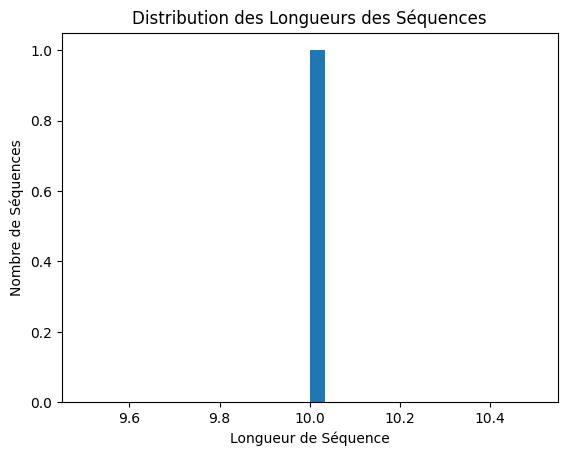

In [21]:
# Visualisation de la distribution des longueurs des séquences
import matplotlib.pyplot as plt
plt.hist(max_sequence_length, bins=30)
plt.xlabel('Longueur de Séquence')
plt.ylabel('Nombre de Séquences')
plt.title('Distribution des Longueurs des Séquences')
plt.show()


In [22]:
# Hyperparamètres et dimensions des données*
taille_num_features = scaled_df.shape[1]
taille_text_features = max_sequence_length # je donne la taille max parmi les longueur des sequences
vocab_size = 20000  
embedding_dim = 128  

In [23]:
from tensorflow.keras.layers import *
import tensorflow as tf



# Entrées
input_num = tf.keras.layers.Input(shape=(taille_num_features,))
input_text = tf.keras.layers.Input(shape=(taille_text_features,))


# Branches du modèle
# Branche numérique - FFN

num_branch = tf.keras.layers.Dense(64, activation='relu')(input_num)
num_branch = tf.keras.layers.Dense(32, activation='relu')(num_branch)



# Branche textuelle - Embedding + Transformer (Un block)

text_branch = Embedding(vocab_size, embedding_dim, input_length=taille_text_features)(input_text)

mask_inputs = masque_remplissage(input_text) 

num_blocks = 4
out_seq = text_branch  # Initialisation avec les embeddings
for _ in range(num_blocks):
    out_seq = Encodeur(
            n_layers=4,
            d_model=128,
            num_heads=8,
            middle_units=256,
            max_seq_len=taille_text_features)([text_branch, mask_inputs])
out_seq = GlobalAveragePooling1D()(out_seq)
out_seq = Dropout(0.3)(out_seq)


# Fusion des branches 

flattened_text_branch = tf.keras.layers.Flatten()(text_branch) # je remodelise les dimension
merged = tf.keras.layers.concatenate([num_branch, flattened_text_branch])

# merged = layers.add([num_branch, text_branch])
# merged = layers.subtract([num_branch, text_branch])
# merged = layers.multiply([num_branch, text_branch])




# Couches supplémentaires après la fusion
merged = tf.keras.layers.Dropout(0.5)(merged)
merged = tf.keras.layers.Dense(16, activation='relu')(merged)

output = tf.keras.layers.Dense(1, activation='sigmoid')(merged)


# Création et compilation du modèle
model = Model(inputs=[input_num, input_text], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           2112        ['input_1[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 10, 128)      2560000     ['input_2[0][0]']                
                                                                                              

In [24]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Entrées pour l'entraînement
data_num = scaled_df   
data_text = pad_sequences(tokens, maxlen=max_length,padding='post')



In [25]:
# Assurez-vous que les données numériques sont correctes
print("Shape of data_num:", data_num.shape)

# Assurez-vous que les données textuelles sont correctes après le rembourrage
print("Shape of data_text:", data_text.shape)

# Assurez-vous que les étiquettes sont correctes
print("Shape of labels:", y.shape)

# NB utiliser le resultat obtenu pour modifier les tailles ou dimension de mes entrées definie plus haut


Shape of data_num: (102774, 32)
Shape of data_text: (102774, 10)
Shape of labels: (102774,)


In [26]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder


# 6. Encodage des étiquettes
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [28]:
from sklearn.model_selection import train_test_split

# 7. Diviser les données en ensembles d'entraînement et de test
X_train_numerical, X_test_numerical, X_train_categorical, X_test_categorical, y_train, y_test = train_test_split(data_num, data_text, y_encoded, test_size=0.2, random_state=42)

In [29]:
history = model.fit([X_train_numerical,X_train_categorical], y_train, epochs=60, batch_size=32, validation_data=([X_test_numerical,X_test_categorical], y_test))


Train on 82219 samples, validate on 20555 samples
Epoch 1/60
82219/82219 [==============================] - ETA: 0s - loss: 0.3192 - accuracy: 0.8159

c:\python install\lib\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


82219/82219 [==============================] - 167s 2ms/sample - loss: 0.3192 - accuracy: 0.8159 - val_loss: 0.2877 - val_accuracy: 0.8328
Epoch 2/60
82219/82219 [==============================] - 159s 2ms/sample - loss: 0.2956 - accuracy: 0.8233 - val_loss: 0.2866 - val_accuracy: 0.8328
Epoch 3/60
82219/82219 [==============================] - 161s 2ms/sample - loss: 0.2914 - accuracy: 0.8260 - val_loss: 0.2849 - val_accuracy: 0.8324
Epoch 4/60
82219/82219 [==============================] - 278s 3ms/sample - loss: 0.2883 - accuracy: 0.8268 - val_loss: 0.2823 - val_accuracy: 0.8332
Epoch 5/60
82219/82219 [==============================] - 304s 4ms/sample - loss: 0.2877 - accuracy: 0.8264 - val_loss: 0.2829 - val_accuracy: 0.8332
Epoch 6/60
82219/82219 [==============================] - 336s 4ms/sample - loss: 0.2876 - accuracy: 0.8255 - val_loss: 0.2816 - val_accuracy: 0.8334
Epoch 7/60
82219/82219 [==============================] - 327s 4ms/sample - loss: 0.2871 - accuracy: 0.8272 - v

In [30]:

#on effectue les prediction sur les donnees de test

y_pred = model.predict([X_test_numerical,X_test_categorical])

print(y_pred)

c:\python install\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[[1.0000000e+00]
 [1.9696495e-01]
 [2.1651557e-01]
 ...
 [4.7084010e-01]
 [2.0485645e-07]
 [2.0485645e-07]]


In [31]:
# necessaire pour afficher la matrix de confusion car a besoin que la probabilité retourner pqr lq fonction sigmoid soir saoit 0 ou 1 pour travailler dessus

y_pred = np.round(y_pred)

In [34]:
# Évaluation du modèle sur les données de test
evaluation_results = model.evaluate([X_test_numerical, X_test_categorical], y_test)
# loss, accuracy = model.evaluate([num_test, text_test], y_pred)


# Affichage des résultats

# print(f'Accuracy: {accuracy}, Loss: {loss}')
print("Perte sur les données de test:", evaluation_results[0])
print("Précision sur les données de test:", evaluation_results[1])


from sklearn.metrics import classification_report


# Afficher le rapport de classification
class_report = classification_report(y_test, y_pred)
print("Rapport de classification :\n", class_report)



Perte sur les données de test: 0.28154277768673847
Précision sur les données de test: 0.83342254
Rapport de classification :
               precision    recall  f1-score   support

           0       0.71      1.00      0.83      8504
           1       1.00      0.72      0.83     12051

    accuracy                           0.83     20555
   macro avg       0.86      0.86      0.83     20555
weighted avg       0.88      0.83      0.83     20555



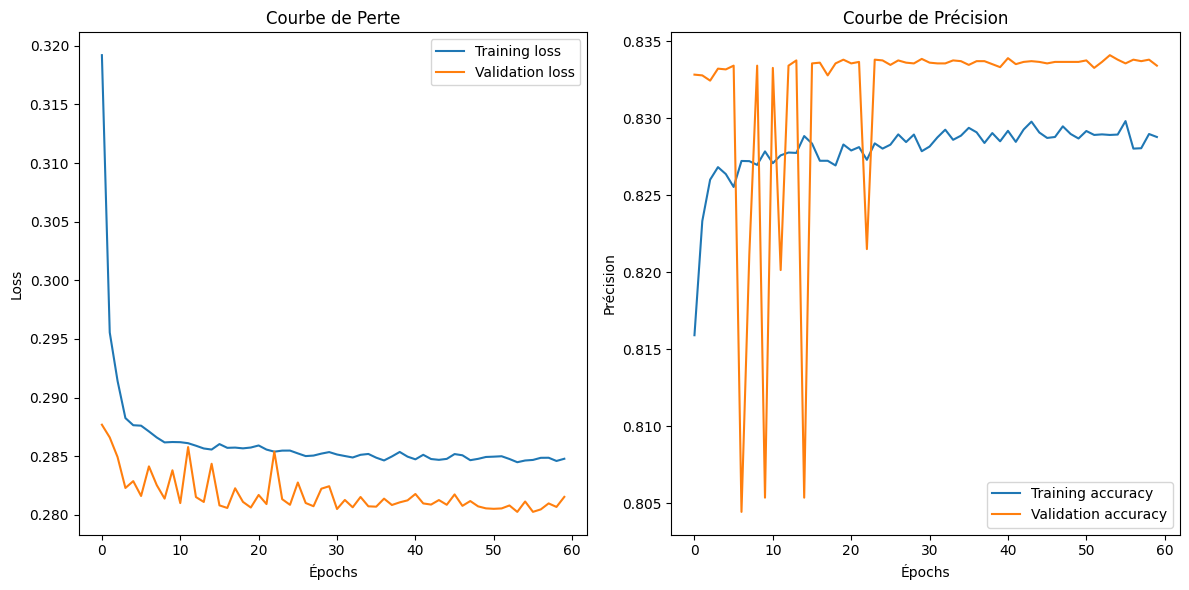

In [35]:
# Affichage des courbes d'apprentissage et de validation
plt.figure(figsize=(12, 6))

# Plot de la perte d'entraînement et de la perte de validation
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Courbe de Perte')
plt.xlabel('Épochs')
plt.ylabel('Loss')
plt.legend()


# Plot de la précision d'entraînement et de la précision de validation
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Courbe de Précision')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

# Afficher les deux sous-plots
plt.tight_layout()
plt.show()

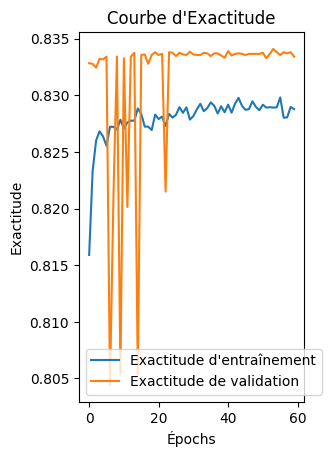

In [38]:
# Courbe d'exactitude
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Exactitude d\'entraînement')
plt.plot(history.history['val_accuracy'], label='Exactitude de validation')
plt.title('Courbe d\'Exactitude')
plt.xlabel('Épochs')
plt.ylabel('Exactitude')
plt.legend()

plt.show()